# Kriging Example 3¶

- Author: Mohit S. Chauhan 
- Date: Mar 03, 2019

In this example, Kriging is used to generate a surrogate model for a given data. In this data, sample points are generated using STS class and functional value at sample points are estimated using a model defined in python script ('python_model_function.py).

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS, RunModel and Krig class from UQpy.

In [1]:
from UQpy.surrogates import Kriging
from UQpy.sampling import RectangularStrata
from UQpy.sampling import TrueStratifiedSampling
from UQpy.RunModel import RunModel
from UQpy.surrogates.kriging.regression_models.baseclass import  Regression
from UQpy.surrogates.kriging.correlation_models.baseclass import Correlation
from UQpy.distributions import Gamma
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
The selected optimizer method does not support bounds and thus will be ignored.
The selected optimizer method does not support bounds and thus

Create a distribution object.

In [2]:
marginals = [Gamma(a=2., loc=1., scale=3.)]

Create a strata object.

In [3]:
strata = RectangularStrata(strata_number=[20])

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [4]:
x = TrueStratifiedSampling(distributions=marginals, strata_object=strata,
                           nsamples_per_stratum=1, random_state=1)

RunModel is used to evaluate function values at sample points. Model is defined as a function in python file 'python_model_function.py'. 

In [5]:
rmodel = RunModel(model_script='python_model_1Dfunction.py', delete_files=True)
rmodel.run(samples=x.samples)

A regression model is defined, this function return the basis function and its jacobian. 

In [6]:
class UserRegression(Regression):
    def r(self, s):
        fx = np.concatenate((np.ones([np.size(s, 0), 1]), s), 1)
        jf_b = np.zeros([np.size(s, 0), np.size(s, 1), np.size(s, 1)])
        np.einsum('jii->ji', jf_b)[:] = 1
        jf = np.concatenate((np.zeros([np.size(s, 0), np.size(s, 1), 1]), jf_b), 2)
        return fx, jf

Gaussian correlation model is defined, which retur covariance matrix and its derivatives. 

In [7]:
class UserCorrelation(Correlation):
    def c(self, x, s, params, dt=False, dx=False):
        x, s = np.atleast_2d(x), np.atleast_2d(s)
        # Create stack matrix, where each block is x_i with all s
        stack = - np.tile(np.swapaxes(np.atleast_3d(x), 1, 2), (1, np.size(s, 0), 1)) + np.tile(s,
                                                                                                (np.size(x, 0), 1,
                                                                                                 1))
        rx = np.exp(np.sum(-params * (stack ** 2), axis=2))
        if dt:
            drdt = -(stack ** 2) * np.transpose(np.tile(rx, (np.size(x, 1), 1, 1)), (1, 2, 0))
            return rx, drdt
        if dx:
            drdx = 2 * params * stack * np.transpose(np.tile(rx, (np.size(x, 1), 1, 1)), (1, 2, 0))
            return rx, drdx
        return rx

Using UQpy Krig class to generate a surrogate for generated data. In this illustration, user defined regression model and correlation model are used.

In [8]:
regression_model = UserRegression()
correlation_model = UserCorrelation()

from UQpy.optimization.MinimizeOptimizer import MinimizeOptimizer
optimizer=MinimizeOptimizer(method="L-BFGS-B")

K = Kriging(regression_model=regression_model,optimizer=optimizer,
            correlation_model=correlation_model,
            optimizations_number=10,
            correlation_model_parameters=[10],
            random_state=2)
K.fit(samples=x.samples, values=rmodel.qoi_list)
print(K.correlation_model_parameters)

/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/optimization/MinimizeOptimizer.py:24: OptimizeWarning: Unknown solver options: catol
  return minimize(function, initial_guess, args=args,
/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/surrogates/kriging/Kriging.py:327: RuntimeWarning: invalid value encountered in log
  ll = (ll + ( np.log(np.linalg.det(sigma_[out_dim] * r__)) + m * (np.log(2 * np.pi) + 1)) / 2)

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *
True
23.90598760735558

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33799D+00    |proj g|=  2.60275D+00

At iterate    1    f= -1.29885D+01    |proj g|=  4.23248D+00
  ys=-4.242E+00  -gs= 6.774E+00 BFGS update SKIPPED

At iterate    2    f= -4.42282D+01    |proj g|=  3.16377D+00
  ys=-3.761E+01  -gs= 1.791E+01 BFGS update SKIPPED

At iterate    3    f= -4.42282D+01    |proj g|=  3.16377D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      7      3     2     1

Kriging surrogate is used to compute the response surface and its gradient.

In [9]:
num = 1000
x1 = np.linspace(min(x.samples), max(x.samples), num)
y, mse = K.predict(x1.reshape([num, 1]), return_std=True)
y_grad = K.jacobian(x1.reshape([num, 1]))

Actual model is evaluated at all points to compare it with kriging surrogate.

In [10]:
rmodel.run(samples=x1, append_samples=False)

This plot shows the input data as blue dot, blue curve is actual function and orange curve represents response curve. This plot also shows the gradient and 95% confidence interval of the kriging surrogate.

|proj g|=  7.29155D+03

At iterate    1    f= -8.65290D+01    |proj g|=  1.21109D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     19      1     0     0   1.211D+00  -8.653D+01
  F =  -86.528997214821899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76248D+01    |proj g|=  5.21623D-04

At iterate    1    f=  2.76248D+01    |proj g|=  5.21623D-04
  ys=-1.269E-13  -gs= 2.721E-07 BFGS update SKI

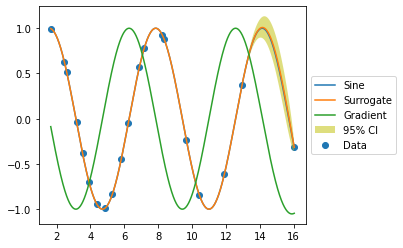

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(x1, rmodel.qoi_list, label='Sine')
plt.plot(x1, y, label='Surrogate')
plt.plot(x1, y_grad, label='Gradient')
plt.scatter(K.samples, K.values, label='Data')
plt.fill(np.concatenate([x1, x1[::-1]]),
         np.concatenate([y - 1.9600 * mse,
                         (y + 1.9600 * mse)[::-1]]),
         alpha=.5, fc='y', ec='None', label='95% CI')
# plt.legend(loc='lower right')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()